In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

from src.utils import normalize_rgb_bands

import torch
import numpy as np
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision.transforms.v2 import ToImage, Compose, CenterCrop
from torch.nn import MSELoss, L1Loss, CrossEntropyLoss

from core.model import UNet
from src.utils import normalize_rgb_bands
from src.transforms import BandNormalize, TargetNormalize


In [2]:
SAMPLES_PATH = "data/samples/samples_S2S5P_2018_2020_eea.csv"

In [37]:
station = "STA-FR30019"
samples_df = pd.read_csv(SAMPLES_PATH, index_col="idx")

sample = np.load(f"no2_visualization/{station}.npy").astype(np.float32)
aiml_pred = np.load(f"no2_visualization/{station}predictions_res10.npy")

# sample = np.load("data/sentinel-2-epa/"+samples_df["img_path"][0]).astype(np.float32)
# no2_truth = samples_df["no2"][0]

(-0.5, 1199.5, 1199.5, -0.5)

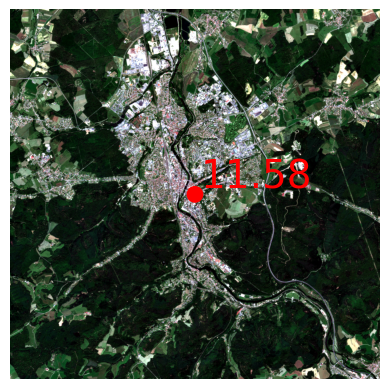

In [38]:
no2_truth = samples_df.loc[samples_df["AirQualityStation"] == station, "no2"].iloc[0]
coords_truth = (sample.shape[0] // 2, sample.shape[1] // 2)


im = plt.imshow(normalize_rgb_bands(sample[:, :, :3]))
circle_truth = patches.Circle(
    coords_truth, radius=25, color="red"
)
im.axes.add_patch(circle_truth)
plt.text(coords_truth[0] + 20, coords_truth[1] - 20,f"{no2_truth:.2f}", color="red", fontsize=28)

plt.axis("off")

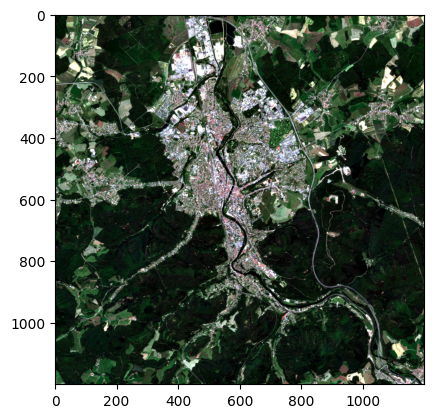

In [39]:
im = plt.imshow(normalize_rgb_bands(sample[:, :, :3]))


(-0.5, 107.5, 107.5, -0.5)

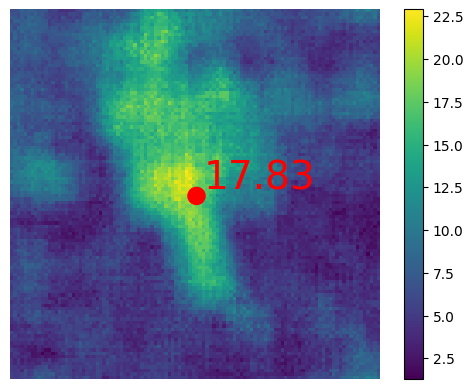

In [40]:
aiml_coords = (aiml_pred.shape[0] // 2, aiml_pred.shape[1] // 2)
no2_pred_aiml = aiml_pred[aiml_coords]

fig, axes = plt.subplots(1, 1)

im = axes.imshow(aiml_pred)
circle_pred = patches.Circle(
    aiml_coords, radius=2.5, color="red"
)
im.axes.add_patch(circle_pred)
plt.text(aiml_coords[0] + 2, aiml_coords[1] - 2,f"{no2_pred_aiml:.2f}", color="red", fontsize=28)
fig.colorbar(im, orientation="vertical")
plt.axis("off")

In [41]:
aiml_coords = (aiml_pred.shape[0] // 2, aiml_pred.shape[1] // 2)

In [42]:
# Parameters
SKIP_CONNECTIONS = False
LAND_COVER = False
CHECKPOINT = "models/sc_lc/sc_false_lc_false.ckpt"
PRED_SIZE = 8
PATCH_SIZE = 128

In [43]:
stats_train = {
    "band_means": np.array(
        [
            951.7304533,
            887.65642278,
            672.43460609,
            2309.22885705,
            1283.86024167,
            1971.3361798,
            2221.09058264,
            2375.07350295,
            2061.81996558,
            1556.39466485,
            565.24740146,
            2376.78314149,
        ]
    ),
    "band_stds": np.array(
        [
            669.08142084,
            533.01636366,
            490.84281537,
            1003.74872792,
            591.48734924,
            739.32762934,
            879.07018525,
            945.72499154,
            813.62533688,
            756.78103222,
            325.27273547,
            869.95854887,
        ]
    ),
    "no2_mean": 20.973578214241755,
    "no2_std": 11.575741710970245,
}


# Create normalizers for bands and NO2 measurements
band_normalize = BandNormalize(stats_train["band_means"], stats_train["band_stds"])
no2_normalize = TargetNormalize(stats_train["no2_mean"], stats_train["no2_std"])

# Create transforms for images and measurements
s2_transform = Compose([ToImage(), band_normalize])
no2_transform = no2_normalize

In [44]:
class_weights = [
    1.88037399e02,
    1.64854777e00,
    5.85467415e01,
    3.36591268e00,
    6.51197767e00,
    1.00000000e00,
    9.56108398e01,
    3.37424575e06,
    1.38434725e01,
    3.68938629e02,
    2.18333547e05,
]


# Define Pytorch lightning model
class Model(L.LightningModule):
    def __init__(self, model, lr, include_lc, lc_loss_weight, lc_class_weights):
        super().__init__()

        # Set model
        self.model = model

        # Set hyperparameters
        self.no2_loss = MSELoss()
        self.no2_mae = L1Loss()
        self.lc_loss = CrossEntropyLoss(weight=torch.tensor(lc_class_weights))
        self.include_lc = include_lc
        self.lc_loss_weight = lc_loss_weight
        self.lr = lr

    def training_step(self, batch, batch_idx):
        no2_loss, no2_mae, lc_loss = self._step(batch)
        total_loss = no2_loss + (self.lc_loss_weight * lc_loss)
        self.log("train_no2_loss", no2_loss)
        self.log("train_no2_mae", no2_mae)
        self.log("train_lc_loss", lc_loss)
        self.log("train_total_loss", total_loss)
        loss = total_loss if self.include_lc else no2_loss
        return loss

    def validation_step(self, batch, batch_idx):
        no2_loss, no2_mae, lc_loss = self._step(batch, batch_idx == 0)
        total_loss = no2_loss + (self.lc_loss_weight * lc_loss)
        self.log("val_no2_loss", no2_loss)
        self.log("val_no2_mae", no2_mae)
        self.log("val_lc_loss", lc_loss)
        self.log("val_total_loss", total_loss)
        loss = total_loss if self.include_lc else no2_loss
        return loss

    def test_step(self, batch, batch_idx):
        no2_loss, no2_mae, lc_loss = self._step(batch)
        total_loss = no2_loss + (self.lc_loss_weight * lc_loss)
        self.log("test_no2_loss", no2_loss)
        self.log("test_no2_mae", no2_mae)
        self.log("test_lc_loss", lc_loss)
        self.log("test_total_loss", total_loss)
        loss = total_loss if self.include_lc else no2_loss
        return loss

    def _step(self, batch, log_predictions=False):
        # Unpack batch
        patches_norm, lc_truth, measurements_norm, coords = batch

        # Get normalized predictions
        predictions_norm, land_cover_pred = self.model(patches_norm)

        # Extract values in coordinate location
        target_values_norm = torch.diag(predictions_norm[:, 0, coords[0], coords[1]])

        # Compute loss on normalized data
        no2_loss = self.no2_loss(target_values_norm, measurements_norm)

        # Center crop
        # lc_truth = CenterCrop(land_cover_pred.shape[-2:])(lc_truth)
        lc_loss = self.lc_loss(land_cover_pred, lc_truth)

        # Compute Mean Absolute Error on unnormalized data
        measurements = no2_normalize.revert(measurements_norm)
        target_values = no2_normalize.revert(target_values_norm)
        no2_mae = self.no2_mae(target_values, measurements)

        if log_predictions:
            self.logger.log_image(
                "images",
                [
                    torch.moveaxis(normalize_rgb_bands(im.cpu()), 0, 2).numpy()
                    for im in patches_norm[:, :3]
                ],
            )
            self.logger.log_image(
                "predictions", list(no2_normalize.revert(predictions_norm))
            )

        return no2_loss, no2_mae, lc_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


# Instantiate Model
unet = UNet(
    (12, 64, 128, 256, 512, 1024),
    (1024, 512, 256, 128, 64),
    SKIP_CONNECTIONS,
)

model = Model.load_from_checkpoint(
    checkpoint_path=CHECKPOINT,
    model=unet,
    lr=0.000005,
    include_lc=LAND_COVER,
    lc_loss_weight=0.1,
    lc_class_weights=class_weights,
)
model.eval()

Model(
  (model): UNet(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): Block(
          (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Block(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Block(
          (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): Block(
          (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (4): Block(
          (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [45]:
H, W, _ = sample.shape

output_rows = []
for i in range(0, H - PATCH_SIZE, PRED_SIZE):
    output_row = []
    for j in range(0, W - PATCH_SIZE, PRED_SIZE):
        patch = sample[i : i + PATCH_SIZE, j : j + PATCH_SIZE]
        patch_norm = s2_transform(patch)
        pred_no2_norm, pred_lc = model.model(patch_norm.unsqueeze(0))
        pred_no2 = no2_normalize.revert(pred_no2_norm.squeeze(0))
        pred_no2 = CenterCrop(PRED_SIZE)(pred_no2)
        pred_no2 = torch.moveaxis(pred_no2, 0, 2).detach().numpy()
        output_row.append(pred_no2)
    print(i)
    output_rows.append(np.hstack(output_row))
output = np.vstack(output_rows)

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064


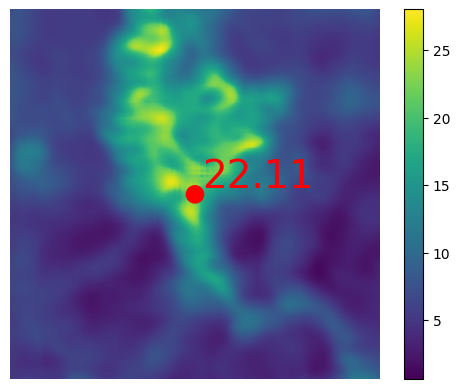

In [46]:
coords_ours = (output.shape[0] // 2, output.shape[1] // 2)
no2_pred_ours = output[coords_ours][0]

fig, axes = plt.subplots(1, 1)

im = axes.imshow(output)
circle_ours = patches.Circle(
    coords_ours, radius=25, color="red"
)
im.axes.add_patch(circle_ours)
plt.text(coords_ours[0] + 20, coords_ours[1] - 20,f"{no2_pred_ours:.2f}", color="red", fontsize=28)

plt.axis("off")
fig.colorbar(im, orientation="vertical")


In [17]:
no2_pred_ours

11.431754

(-0.5, 1071.5, 1071.5, -0.5)

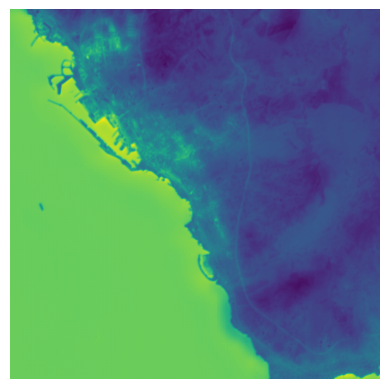

In [89]:
plt.imshow(output)
plt.axis("off")

In [91]:
no2_pred_ours

array([19.371231], dtype=float32)

In [47]:
len(samples_df)

3100